### The NN can approximate a GP

For a single layer NN, the function can be:
$h^{(0)}_j = \phi(w^{(0)}_{j}x + b^{(0)}_j)$,
$y = \sum_j^N{(w_j^{(1)}h^{(0)}_j + b^{(1)})}$

When the weight $w$ and bias $b$ are i.i.d (independently and identically distributed).
All of the parameters are linearly distributed according to $\mathcal{U}(-\frac{1}{\sqrt{h}}, \frac{1}{\sqrt{h}})$,
where $h$ is the number of inputs of this layer.

### Derivation of the link between NN and GP
According to the Central Limit Theorem (CLT), the sum of the infinite i.i.d. variables
converges to a normal distribution.

For a singular $y$, we have
$E(y) = 0$,
$\mathrm{Cov}\left(y(x), y(x')\right) = E\left(y(x)y(x')\right) - E\left(y(x)\right)E\left(y(x')\right) $

$=E\left( \sum_i\sum_j (w^{(1)}_i w^{(1)}_j h_i h_j)+b^{(1)2}\right)$
$=\sum_i\sum_j \left( E\left(w^{(1)}_i w^{(1)}_j h_i h_j\right)\right) + \sigma_{b^{(1)}}^2$
$=\sum_i\sum_j \left( E\left(w^{(1)}_i w^{(1)}_j\right)E\left(h_i h_j\right)\right) + \sigma_{b^{(1)}}^2$

Here we have:
 $E\left(w^{(1)}_i w^{(1)}_j\right) = \delta_{ij}\sigma^2_{w^{(1)}}$, where $\delta_{ij}$ is the Dirichlet
 operator. So, the covariance can be written as:
$\mathrm{Cov}\left(y(x), y(x')\right) =\sum_i\sum_j \left( \delta_{ij}\sigma^2_{w^{(1)}}E\left(h_i h_j\right)\right) + \sigma_{b^{(1)}}^2 $,
$= \sigma^2_{w^{(1)}}  \sum_k  E\left(h_k(x) h_k(x')\right) + \sigma_{b^{(1)}}^2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pandas as pd
import  time

# plot configuration
mpl.rcParams['figure.dpi'] = 100
# fix random seeds
axes = {'labelsize' : 'large'}
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize' : 7}
mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)

nx = 101
x = np.linspace(-1.0, 1., nx)[:, np.newaxis]

# Gaussian process

The distribution on every single $x$ should be a **Gaussian distribution**.

In [2]:
def kernel_rbf(x1, x2, sig=1.0, l=1.0):
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    K = sig**2 * np.exp(-(x1 - x2.T)**2/(2*l**2))
    return K

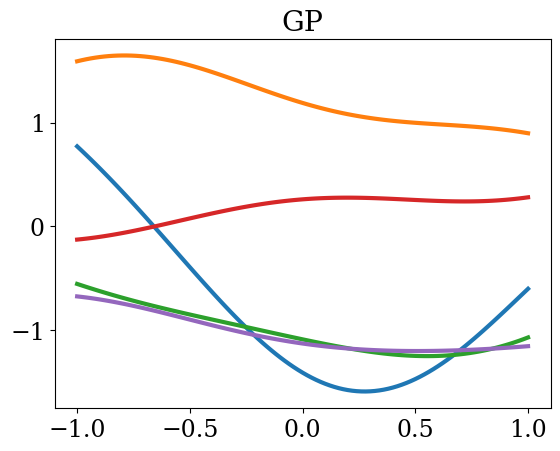

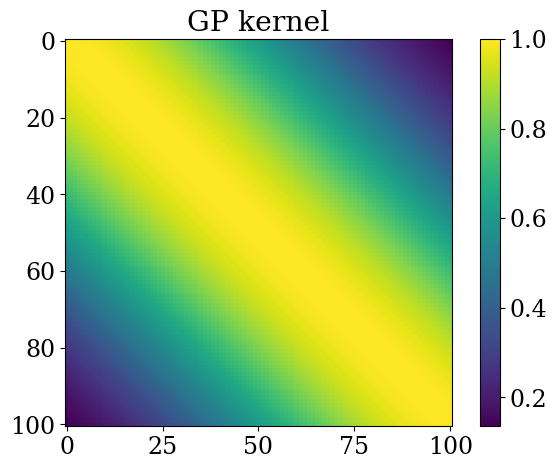

In [3]:
x_temp = -(x.T - x)**2/2.
kernel = kernel_rbf(x, x)
# kernel = np.exp(-(x.T - x)**2/2.)
def rand_gen_GP(num_samples = 5):
    y = np.random.multivariate_normal(mean=np.zeros(shape=nx), cov=kernel, size=num_samples)
    return y
y = rand_gen_GP()
plt.plot(x.reshape(-1), y.T)
plt.title('GP')
fig = plt.gcf()
fig.savefig(fname = './figs/GP sampling.jpg', dpi=200)
plt.show()
plt.close()

plt.imshow(kernel); plt.colorbar(); plt.tight_layout()
plt.title('GP kernel')
fig = plt.gcf()
fig.savefig(fname = './figs/GP kernel_true.jpg', dpi=200)
plt.show()
plt.close()

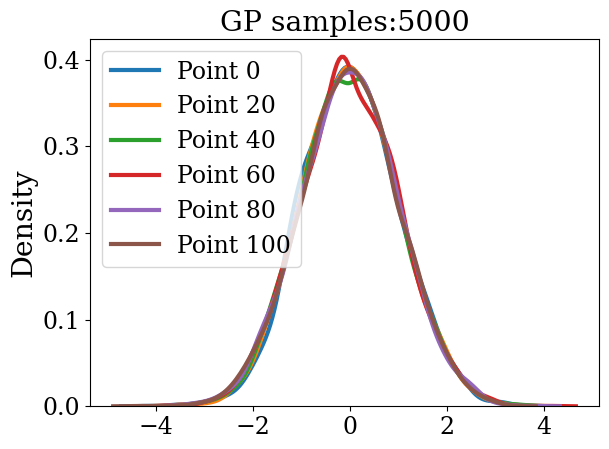

In [4]:
import seaborn as sns

num_samples = 5000

y_gp = rand_gen_GP(num_samples=num_samples)

for i in range(0, nx, nx//5):
    sns.kdeplot(y_gp[:, i], label='Point %d' % i)
plt.title('GP samples:%d' % (num_samples))
plt.legend()
plt.tight_layout()
fig = plt.gcf()
fig.savefig(fname = './figs/GP kernel_samples_at_points.jpg', dpi=200)
plt.show()
plt.close()

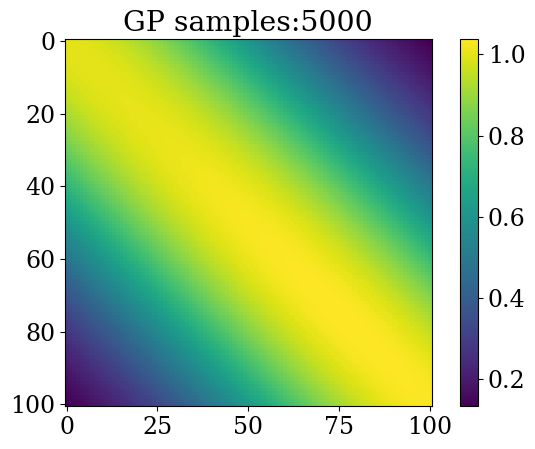

In [5]:
k_sample = np.einsum('mi, mj->ij', y_gp, y_gp)/num_samples

plt.imshow(k_sample)
plt.colorbar()
plt.title('GP samples:%d' % (num_samples))
plt.tight_layout()
fig = plt.gcf()
fig.savefig(fname = './figs/GP kernel_samples.jpg', dpi=200)
plt.show()
plt.close()


# NN converges to a Gaussian process

In [6]:
class basicNN(torch.nn.Module):
    def __init__(
            self, hidden_num=100, activation='sigmoid',
            sigma_u=5.0, sigma_a=5.0, sigma_v=1.0, sigma_b=0.1):
        super(basicNN, self).__init__()
        if activation=='sigmoid':
            self.activation = torch.nn.Sigmoid()
        elif activation=='relu':
            self.activation=torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        elif activation == 'linear':
            self.activation = self.linear_activation
        elif activation == 'sin':
            self.activation = torch.sin
        elif activation == 'bessel':
            self.activation = self.bessel0_activation
        else:
            raise

        # self.l1 = torch.nn.Linear(1, hidden_num, bias=False)
        # self.l2 = torch.nn.Linear(hidden_num, 1, bias=False)

        self.w1 = torch.randn(size=[1, hidden_num])*sigma_u
        self.w2 = torch.randn(size=[hidden_num, 1])/np.sqrt(hidden_num)*sigma_v
        self.b1 = torch.randn(size=[hidden_num]) * sigma_a
        self.b2 = torch.randn(size=[1])*sigma_b

    def forward(self, x):
        x = self.activation(x@self.w1 + self.b1)@ self.w2 # + self.b2
        # x = self.l2(self.activation(self.l1(x)))
        return x

    def linear_activation(self, x):
        return x

    def bessel0_activation(self, x):
        # t = torch.ones_like(x)
        # s_um = torch.ones_like(x)
        # x_half_2 = ( x / 2)**2
        # for i in range(1, 40):
        #     t *= -x_half_2/i**2
        #     s_um += t
        # x_temp = 4. * x
        s_um = torch.special.bessel_j0(x)
        return s_um

## Results in Neal's thesis (Neal 1996) Page 33

$ f(x) = b_k + v_{jk} h_j(x)$

$ h_j(x) = \mathrm{act.}(a_j + u_{ij} x_i )$

<Figure size 640x480 with 0 Axes>

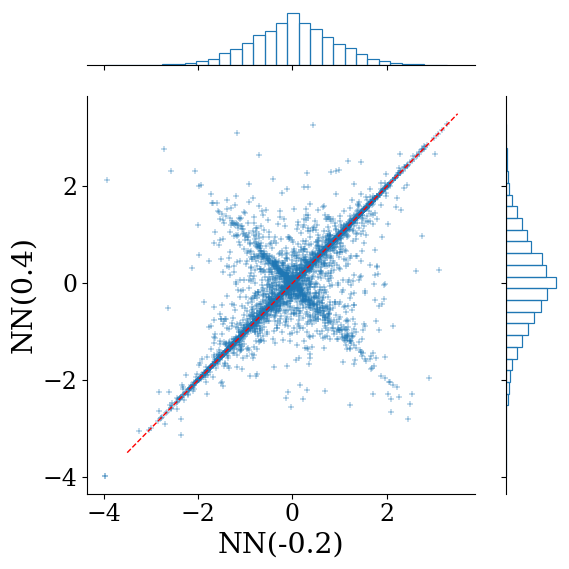

<Figure size 640x480 with 0 Axes>

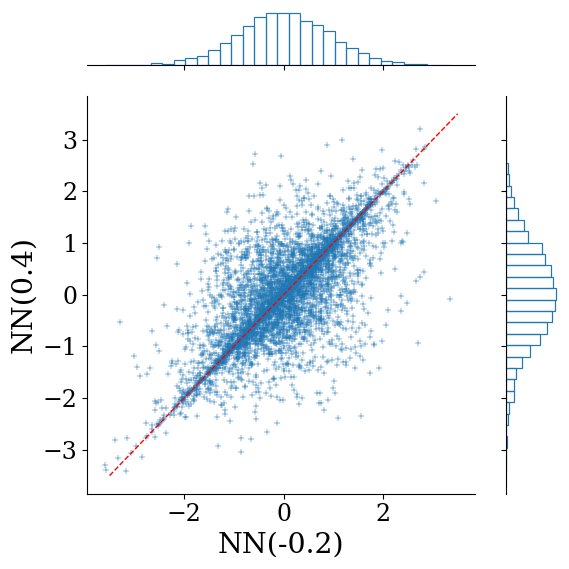

<Figure size 640x480 with 0 Axes>

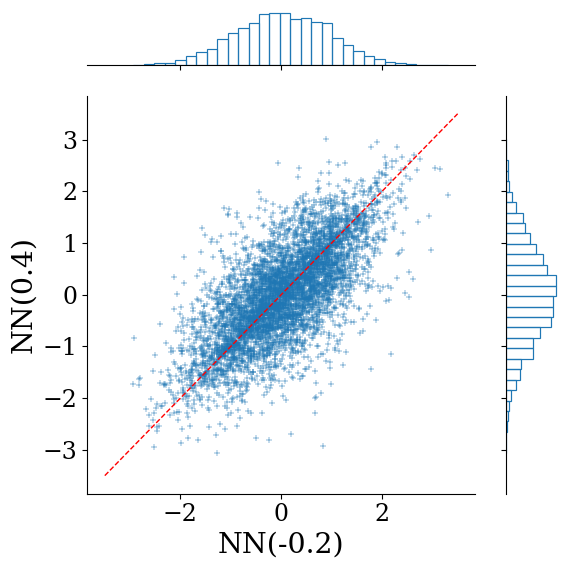

<Figure size 640x480 with 0 Axes>

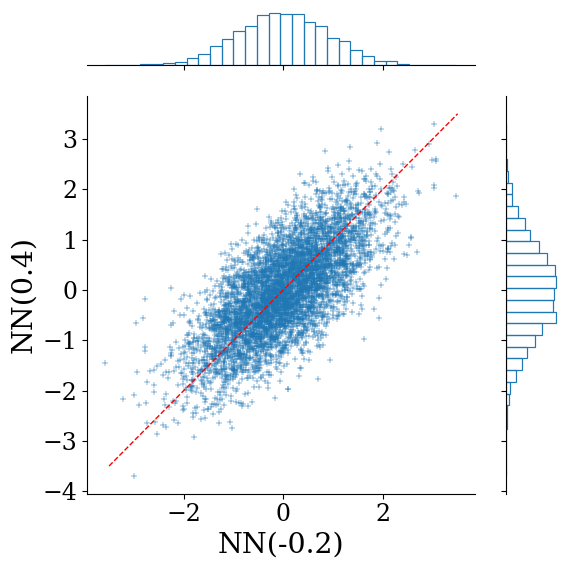

In [7]:
def neal_1996(hidden=1, num_samples=5000, activation='tanh'):
    y = []
    x_temp = np.array([-0.2, 0.4]).reshape(-1, 1)
    for i in range(num_samples):
        model = basicNN(hidden_num=hidden, activation=activation)
        with torch.no_grad():
            y.append(model(torch.from_numpy(x_temp).float()).numpy().reshape(-1))
    y = np.array(y)

    y_dataframe = pd.DataFrame(data=y, columns=['NN(-0.2)', 'NN(0.4)'])
    # plot the distribution
    fig = plt.figure()
    # sns.kdeplot(y[:, 0], label=r'$NN(-0.2)$')
    # sns.kdeplot(y[:, 1], label=r'$NN(0.4)$')
    sns.jointplot(data=y_dataframe, x='NN(-0.2)', y='NN(0.4)',
                  marker="+", s=20, marginal_kws=dict(bins=30, fill=False),)
    plt.plot([-3.5, 3.5], [-3.5, 3.5], '--r', linewidth=1.0)
    # plt.title('NN nodes: %d' % hidden)
    # plt.legend()
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(fname = './figs/neal_1996_nodes%d.jpg' % hidden, dpi=200)
    plt.show()
    plt.close()

    # plot the distribution of NN(0.4) wrt NN(0.2) in a range
    # position = 0.3
    # width = 0.05
    # y_0 = []
    # y_minus_1 = []
    # y_1 = []
    # for i in y[:, 0]:
    #     if -width<i<width:
    #         y_0.append(i)
    #     elif -width-position<i<width-position:
    #         y_minus_1.append(i)
    #     elif -width+position<i<width+position:
    #         y_1.append(i)
    # plt.violinplot([y_minus_1, y_0, y_1])
    # plt.show()
    # plt.close()


    # plot the points
    # plt.figure(figsize=(6, 6))
    # plt.scatter(y[:, 0], y[:, 1], s=2, edgecolors='k')
    # plt.plot([-4, 4], [-4, 4], '--r', linewidth=1.0)
    # plt.xlabel(r'$NN(-0.2)$')
    # plt.ylabel(r'$NN(0.4)$')
    # plt.axis('equal')
    # plt.xlim([-3.5, 3.5])
    # plt.ylim([-3.5, 3.5])
    # plt.title('NN nodes: %d' % hidden)
    # plt.tight_layout()
    # fig = plt.gcf()
    # fig.savefig(fname = './figs/neal_1996_nodes%d.jpg' % hidden, dpi=200)
    # plt.show()
    # plt.close()
    return

neal_1996(hidden=1)
neal_1996(hidden=3)
neal_1996(hidden=10)
neal_1996(hidden=1000)

In [8]:
def rand_gen_NN(hidden=100, num_samples = 5, activation='sigmoid'):
    y = []
    for i in range(num_samples):
        model = basicNN(hidden_num=hidden, activation=activation)
        with torch.no_grad():
            y.append(model(torch.from_numpy(x).float()).numpy().reshape(-1))
    return np.array(y)


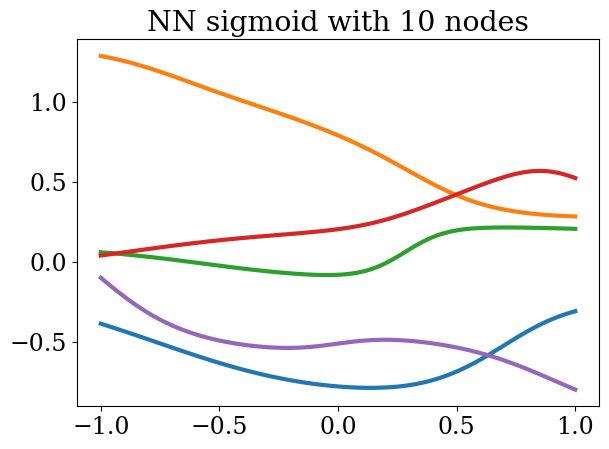

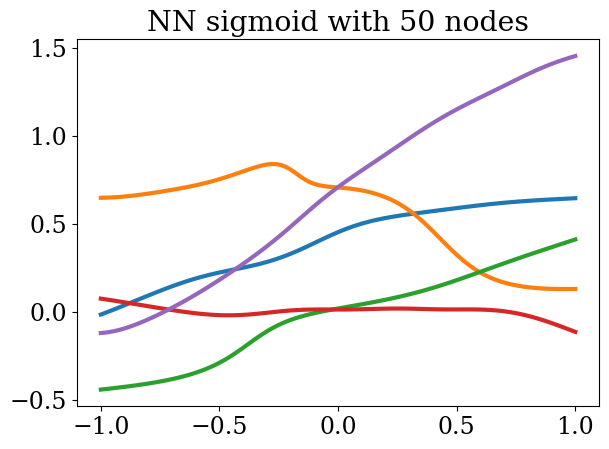

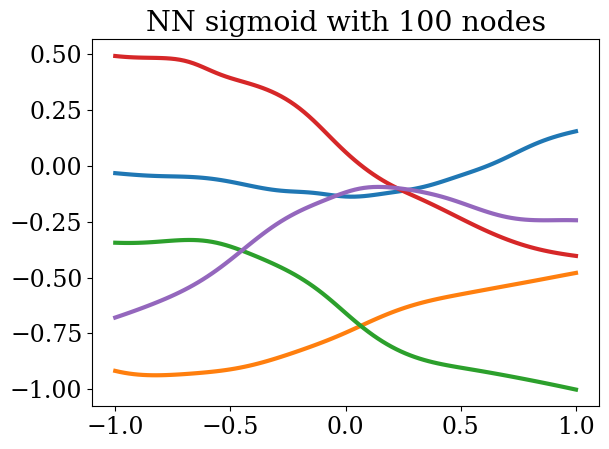

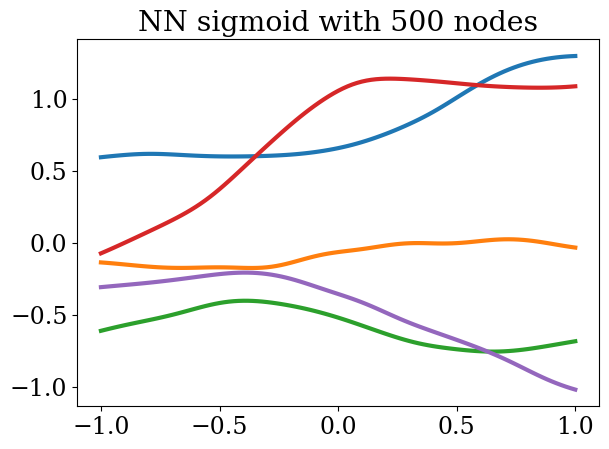

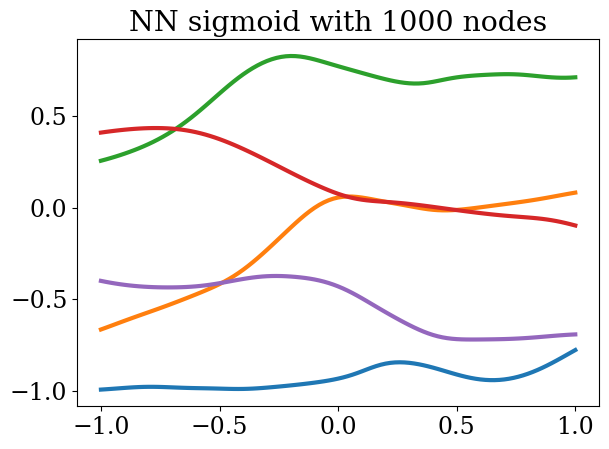

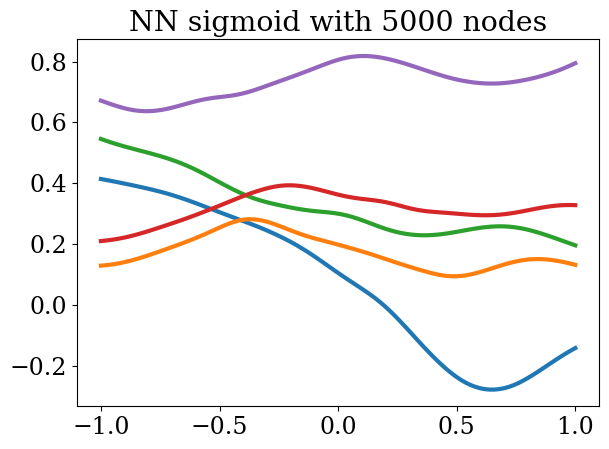

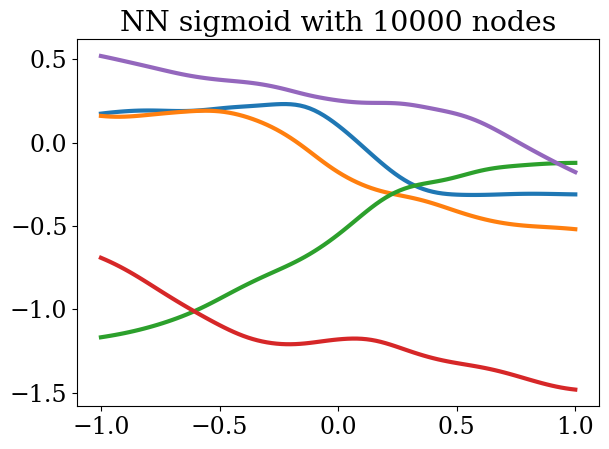

In [9]:
activation = 'sigmoid'
hidden_node_list = [10, 50, 100, 500, 1000, 5000, 10000]
for i in hidden_node_list:
    y = rand_gen_NN(hidden=i)
    plt.plot(x.reshape(-1), y.T)
    plt.title('NN %s with %d nodes' % (activation, i))

    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(fname = './figs/NN_nodes%d_samples.jpg' % i, dpi=200)
    plt.show()
    plt.close()
    


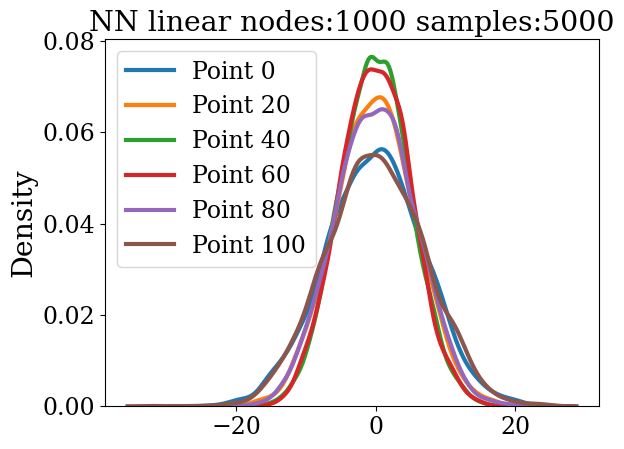

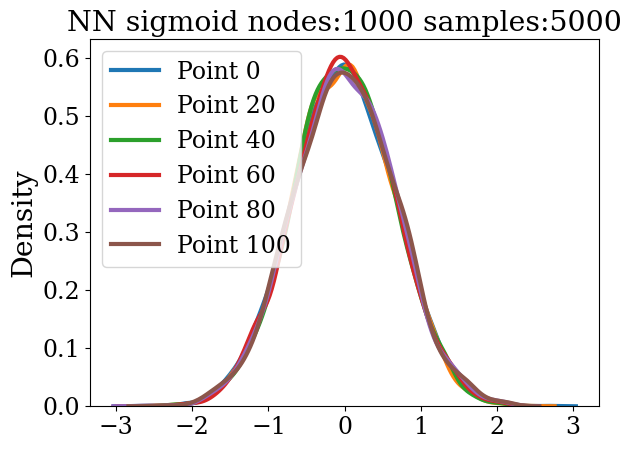

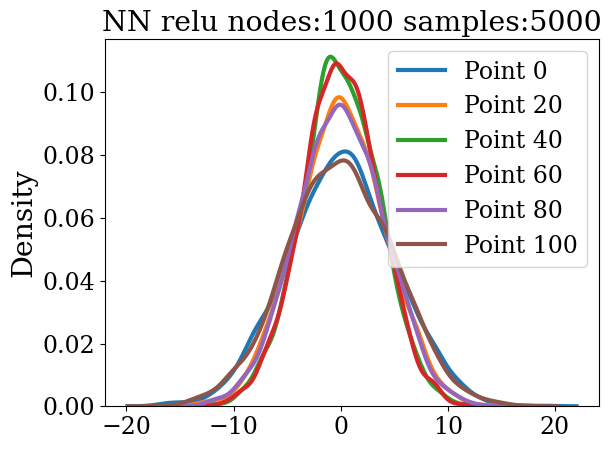

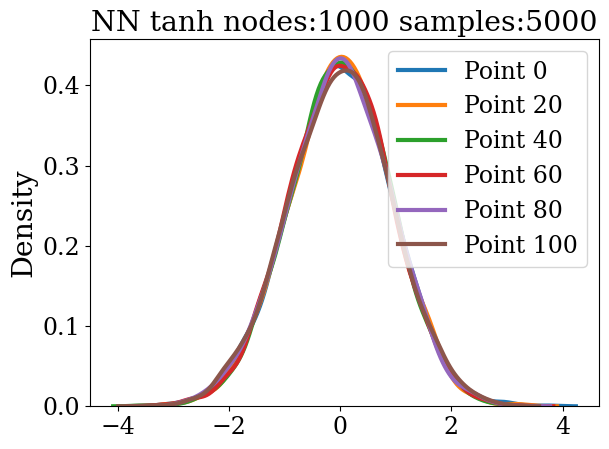

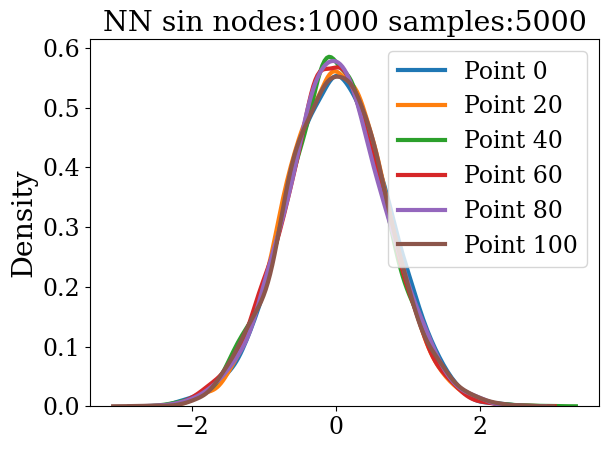

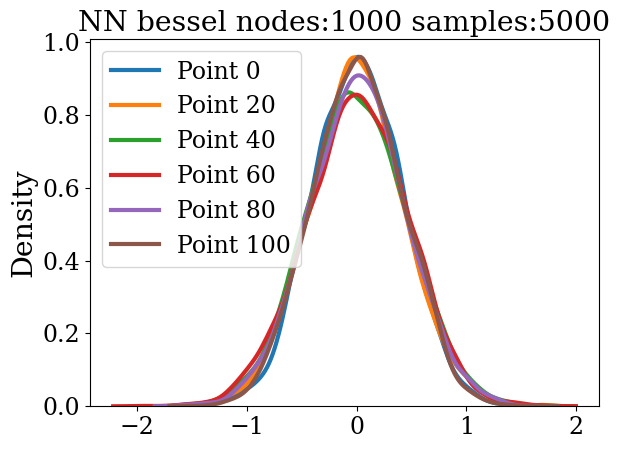

In [10]:
hidden_node_num = 1000
num_samples = 5000
activation = 'sigmoid'

def mask(hidden_node_num, num_samples, activation):
    y_nn = rand_gen_NN(hidden=hidden_node_num, num_samples=num_samples, activation=activation)

    for i in range(0, nx, nx//5):
        sns.kdeplot(y_nn[:, i], label='Point %d' % i)
    plt.title('NN %s nodes:%d samples:%d' % (activation, hidden_node_num, num_samples))
    plt.legend()

    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(fname = './figs/NN_%s_nodes%d_variance_at_points.jpg' % (activation, hidden_node_num), dpi=200)
    plt.show()
    plt.close()
    return

for act_temp in ['linear', 'sigmoid', 'relu', 'tanh', 'sin', 'bessel']:
    mask(hidden_node_num=hidden_node_num, num_samples=num_samples, activation=act_temp)


Comparing the three activation functions, we can find: 
- the kernel of the NN prediction is not **stationary**, while the RBF kernel is stationary.
Theoretically, because there is term of $x \otimes x'$ in the NN kernel function
$k(x, x') = \int NN(x | \Theta) NN(x'|\Theta) p(\Theta) d \Theta $.
- $\sin (x)$, $\mathrm{Sigmoid}(x)$ and $\mathrm{tanh}(x)$ are more close to
the stationary Gaussian process. while the linear, relu and the bessel function are more
nonstationary. For linear, relu, Sigmoid and tanh activation, the result is symmetrical with respect
 to the intermediate point (point 50). The variance is larger for the middle point and
 smaller for the two sides.
- $Sigmoid$ and $Tanh$ activation function are nearly the same distribution 
except the amplitude. Because the two activations are nearly in the same shape.
$\mathrm{Sigmoid}(x) = \frac{1}{1+e^{-x}} $, and
$\mathrm{tanh}(x) = \frac{e^{x} -e^{-x}}{e^{x} + e^{-x}}$.


**Some theoretical results based on Wiliams 1997 should be displayed here to support the numerical experiments**?



# Numerical integration of the NN kernel

$\mathrm{Cov}(y, y') = E (y \cdot y') - E(y) \cdot E(y') = E \left( \left( w_1 (w_0x+b_0 )+b_1 \right) \cdot \left( w_1 (w_0 x'+b_0 )+b_1 \right) \right) \\$
$ = $

**Why the kernel is not like the kernel of the RBF kernel??**
- the kernel generated by the network will not be similar with the RBF kernel as the analytical 
    format is different from the RBF kernel.
- For example, with regard to the single hidden layer NN with $\mathrm{ReLU}(\cdot)$ activation,
    the kernel can be evaluated:
    - the covariance of $z^0_i (x) = \sum_j^{d_in} w^0_{ij}x_j + b^{0}_{i}$, $i$ indicates that it
    is the ith outputs of the hidden layer.
    Its covariance can be evaluated as:
    $\mathrm{Cov}(z^0_i (x), z^0_i (x')) = k^0(x, x') = x^T \Lambda x^\prime + \sigma_{b,0}^2 \\$
    where the shape of $Lambda$ is $(d_{in}, d_{in})$
    - The equations are so complex, please see Pang Guofei 2018. ...

## Analytical kernel of the single hidden NN with ReLU activation

according to the Pang Guofei 2018

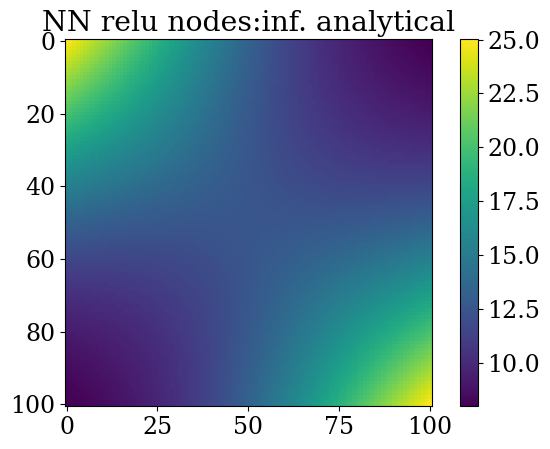

In [11]:
sigma2_w_0 = 5.0**2
sigma2_w_1 = 1.0**2
sigma2_b_0 = 5.0**2
sigma2_b_1 = 0.1**2
d_in = 1
eye_nx = np.eye(nx)
eye_d = np.eye(d_in)*sigma2_w_0
k_0 = np.einsum('id, dd, jd', x, eye_d, x ) + sigma2_b_0
# k_0 = np.einsum('id, dd, jd', x, eye_d, x ) + sigma2_b_0

term1 = sigma2_w_1/2./np.pi
k_1 = np.zeros(shape=[nx, nx])
for i in range(nx):
    for j in range(nx):
        temp = np.sqrt(k_0[i, i] * k_0[j ,j])
        theta = np.arccos(k_0[i, j]/temp)
        k_1[i, j] = term1*temp * (np.sin(theta) + (np.pi - theta) * np.cos(theta)) + sigma2_b_1
# k_1 = k_1 + eye_nx*sigma2_b_1

plt.imshow(k_1)
plt.colorbar()
plt.title('NN %s nodes:inf. analytical' % ('relu'))
plt.tight_layout()
fig = plt.gcf()
fig.savefig(fname = './figs/NN_relu_inf_analyt._kernel.jpg', dpi=200)
plt.show()
plt.close()


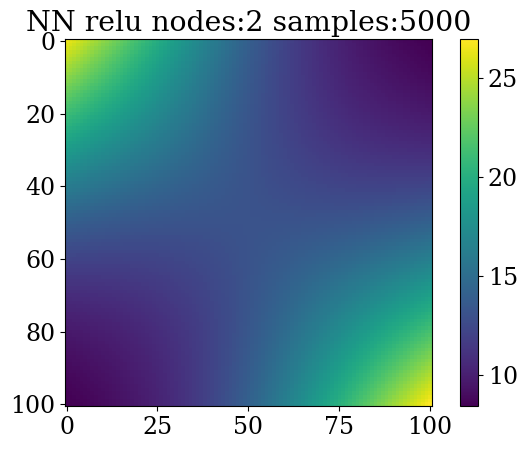

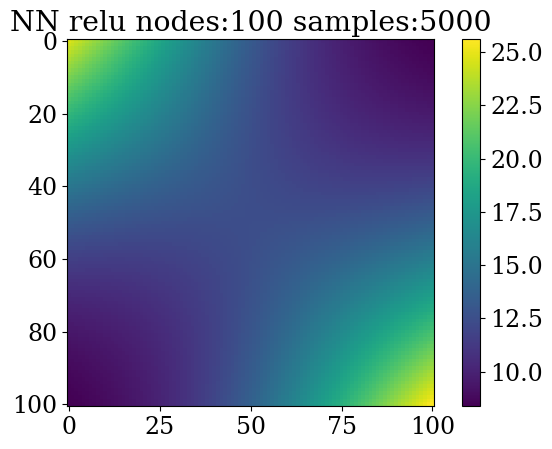

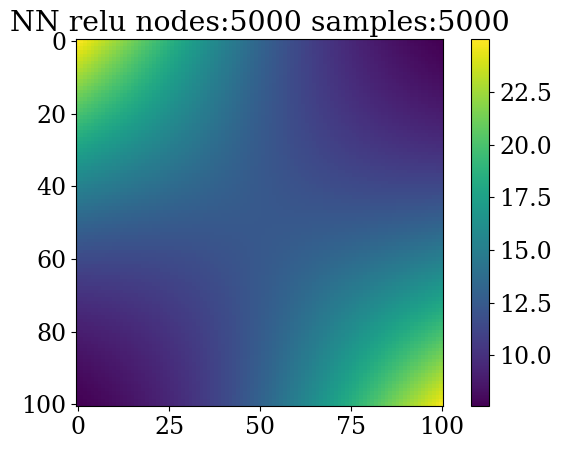

In [12]:
def plot_nn_kernel(
        activation, hidden_node,
    num_samples = 5000):
    y_nn = rand_gen_NN(hidden=hidden_node, num_samples=num_samples, activation=activation)

    k_nn = np.einsum('mi, mj->ij', y_nn, y_nn)/num_samples

    plt.imshow(k_nn)
    plt.colorbar()
    plt.title('NN %s nodes:%d samples:%d' % (activation, hidden_node, num_samples))
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(fname = './figs/NN_%s_nodes%d_kernel.jpg' % (activation, hidden_node), dpi=200)
    plt.show()
    plt.close()
    return k_nn
# for i in ['linear', 'sigmoid', 'tanh', 'relu', 'sin', 'bessel']:
for activation in ['relu',]:
    for node in [2, 100, 5000]:  # [2, 10, 100, 5000]
        for num_samples in [5000]:
            k_nn = plot_nn_kernel(
                activation=activation, hidden_node=node, num_samples=num_samples)


## Kullback–Leibler divergence evaluation
Here, we use the divergence of the NN prediction distribution and the real Gaussian process to describe the difference
between the two distribution.

The Kullback–Leibler divergence can be evaluated as:
$\mathcal{D}_{KL}(P\|Q) = \sum_{x\in\mathcal{X}}P(x)\log{\left(\frac{P(x)}{Q(x)}\right)} \\$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = \sum_{x\in\mathcal{X}}P(x)\left(\log{P(x)} - \log{Q(x)}\right) \\$

And the probability distribution of a Gaussian Process can be expressed as:
$Q(f|X) = \frac{1}{(2\pi)^{n/2}|K|^{1/2}}\exp{(-\frac{1}{2}f^T K^{-1} f)} \\$
$\log{Q(f|X)} =  -\frac{1}{2}f^T K^{-1} f  - \frac{n}{2}\log{2\pi} - \frac{1}{2}\log{|K|}$

The probability distribution of a Gaussian Process is also influenced by the hyper-parameters.

**So how to give proper hyper-parameters to analogy the NN and GP?**

C:\Users\shguan\AppData\Local\Temp\ipykernel_18148\695252575.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_gp = np.random.multivariate_normal(mean=np.zeros(nx), cov=k_nn, size=3)


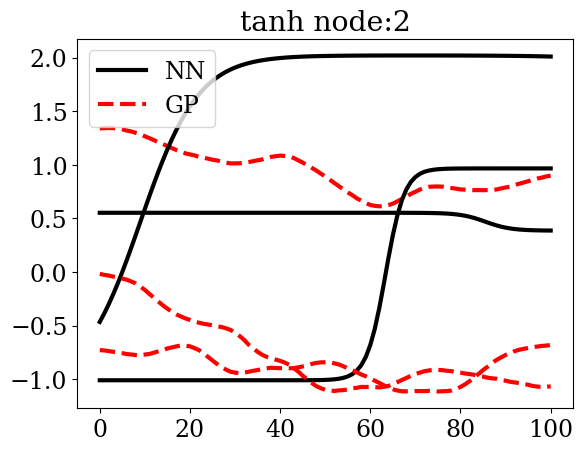

C:\Users\shguan\AppData\Local\Temp\ipykernel_18148\695252575.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_gp = np.random.multivariate_normal(mean=np.zeros(nx), cov=k_nn, size=3)


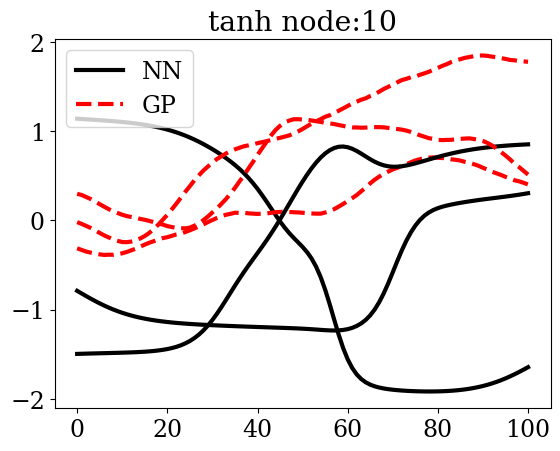

C:\Users\shguan\AppData\Local\Temp\ipykernel_18148\695252575.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_gp = np.random.multivariate_normal(mean=np.zeros(nx), cov=k_nn, size=3)


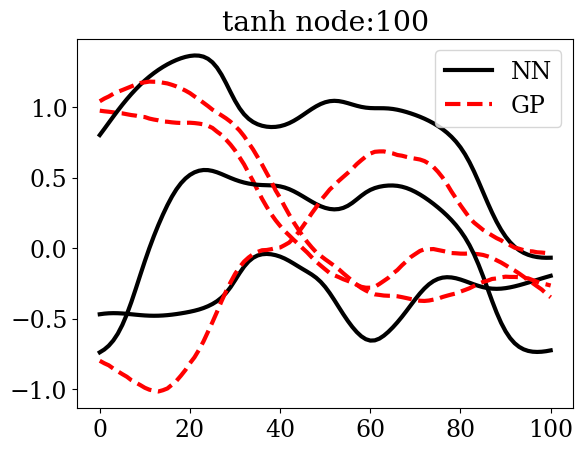

C:\Users\shguan\AppData\Local\Temp\ipykernel_18148\695252575.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_gp = np.random.multivariate_normal(mean=np.zeros(nx), cov=k_nn, size=3)


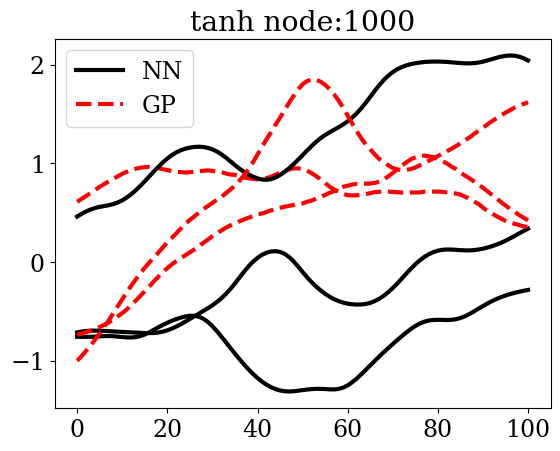

In [13]:
def plot_samples(hidden_node, activation = 'tanh', num_samples=1000):

    # compute the NN kernel then used in the Gaussian sampling
    y_nn = rand_gen_NN(hidden=hidden_node, num_samples=num_samples, activation=activation)
    k_nn = np.einsum('mi, mj->ij', y_nn, y_nn)/num_samples

    y_gp = np.random.multivariate_normal(mean=np.zeros(nx), cov=k_nn, size=3)

    y = rand_gen_NN(hidden=hidden_node, num_samples=num_samples, activation=activation)
    plt.title('%s node:%d' % (activation, hidden_node))
    plt.plot(y[0].T, 'k', label='NN')
    plt.plot(y_gp[0].T, '--r', label='GP')
    plt.plot(y[1:3].T, 'k')
    plt.plot(y_gp[1:3].T, '--r')
    plt.legend()
    fig=plt.gcf()
    fig.savefig('figs/gaussian_NN_sample_based_on_NNkernel_%s_node%d.jpg' % (activation, hidden_node),
                dpi=200)
    plt.show()
for hidden_node in [2, 10, 100, 1000]:
    plot_samples(hidden_node=hidden_node)

In [34]:
def mask_divergence(hidden_node=2, num_samples=5000, activation='tanh'):
    p_per = 1./num_samples
    # log_2pi = np.log(2*np.pi)
    K_inv = np.linalg.inv(k_nn  + np.eye(nx)*1e-3)
    # K_det = np.linalg.det( k_nn + np.eye(nx)*1e-3)
    # log_k_det_half = np.log(K_det)
    y = rand_gen_NN(hidden=hidden_node, num_samples=num_samples, activation=activation)
    '''
    2 -92.5579582080821
    10 -131.5543395864393
    100 -131.34334480560432
    5000 -123.62785283796535
    '''

    term1_sum =  0.
    for f in y:
        term1_sum += np.exp(-0.5* np.einsum('i, ij, j->', f, K_inv, f))
        # log_Q = - (0.5* np.einsum('i, ij, j->', f, K_inv, f) + 0.5*nx *log_2pi + 0.5*log_k_det_half)
        # D_KL += (np.log(p_per) - log_Q
        #          )/num_samples

    D_KL = 0.
    for f in y:
        term1_normalized = np.exp(-0.5* np.einsum('i, ij, j->', f, K_inv, f))/term1_sum
        # log_Q = - (0.5* np.einsum('i, ij, j->', f, K_inv, f) + 0.5*nx *log_2pi + 0.5*log_k_det_half)
        D_KL += (np.log(p_per) - np.log(term1_normalized)
             )/num_samples

    return D_KL

divergence = []
num_list = [2, 10, 100, 200, 500, 1000, 10000, 100000]
for hidden_node in num_list:
    print('\n' + '-'*60)
    print('\tBegin nodes: %d' % hidden_node)
    time_start = time.time()
    divergence.append(mask_divergence(hidden_node=hidden_node, num_samples=5000))
    print('\tFinished nodes: %d consumed %.2f mins' % (hidden_node, time.time() - time_start))


Finished 2
Finished 10
Finished 100
Finished 200
Finished 500
Finished 1000
Finished 10000
Finished 100000


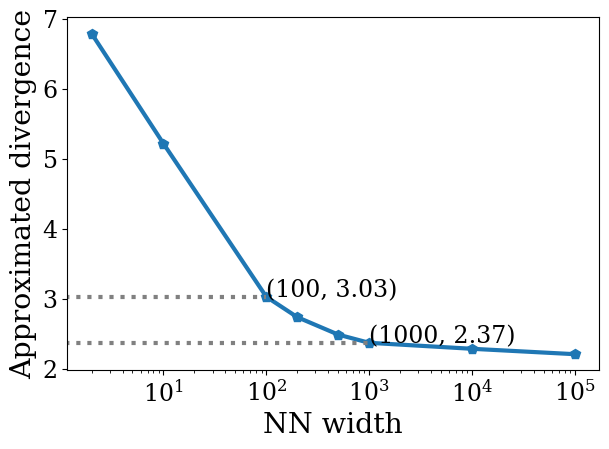

In [43]:
plt.plot(num_list, divergence, marker = 'p')
# plt.axis('xlog')
plt.ylabel('Approximated divergence')
plt.xlabel('NN width')
plt.plot([0, 100], [divergence[2], divergence[2]], linestyle='dotted', color='gray')
plt.plot([0, 1000], [divergence[5], divergence[5]], linestyle='dotted', color='gray')

plt.text(x=100, y= divergence[2], s='(%d, %.2f)' % (100, divergence[2]),
         # bbox=dict(facecolor='tab:red', alpha=0.5)
         )

plt.text(x=1000, y= divergence[5], s='(%d, %.2f)' % (1000, divergence[5]),
         # bbox=dict(facecolor='tab:red', alpha=0.5)
         )
ax = plt.gca()
ax.set_xscale('log')
plt.tight_layout()
fig = plt.gcf()
fig.savefig('./figs/approximated KL distance.png', dpi=200)
plt.show()
plt.close()
